In [11]:
import sys, os
print(sys.executable)
print(os.getcwd())

C:\Users\chenr\miniforge3\envs\astropy\python.exe
C:\Users\chenr\OneDrive\Desktop\phys-134-proj


In [ ]:
rootfolder=os.getcwd().replace('\\','/')
print(rootfolder)

C:/Users/chenr/OneDrive/Desktop/phys-134-proj/lco_data-20251202-36


In [ ]:
os.chdir(f"{rootfolder}/lco_data-20251202-36")
os.getcwd()

'C:\\Users\\chenr\\OneDrive\\Desktop\\phys-134-proj\\lco_data-20251202-36'

In [ ]:
import pickle 
with open('region_data.pkl', 'rb') as f:
    region_data = pickle.load(f)

In [17]:
#get array of files in directory
file_list=os.listdir(".")

# filter to only .fits files
file_list=[f for f in file_list if f.endswith('.fits') and f.startswith('2025')]
print(file_list)

['2025-11-25-h02-m00-s14-ms936-tfn.fits', '2025-11-25-h05-m00-s13-ms688-lsc.fits', '2025-11-25-h05-m36-s42-ms454-lsc.fits', '2025-11-25-h06-m06-s14-ms909-lsc.fits', '2025-11-25-h07-m45-s12-ms840-elp.fits', '2025-11-25-h08-m30-s09-ms718-elp.fits', '2025-11-25-h09-m06-s12-ms841-elp.fits', '2025-11-25-h10-m06-s14-ms367-elp.fits', '2025-11-25-h11-m06-s18-ms072-elp.fits', '2025-11-25-h12-m47-s39-ms526-ogg.fits', '2025-11-25-h13-m06-s13-ms287-ogg.fits', '2025-11-25-h14-m06-s15-ms196-ogg.fits', '2025-11-25-h23-m02-s40-ms929-tfn.fits', '2025-11-25-h23-m35-s17-ms210-cpt.fits', '2025-11-26-h00-m55-s17-ms907-tfn.fits', '2025-11-26-h01-m55-s17-ms940-tfn.fits', '2025-11-26-h02-m10-s07-ms425-tfn.fits', '2025-11-26-h03-m06-s19-ms581-tfn.fits', '2025-11-26-h04-m06-s16-ms133-tfn.fits', '2025-11-26-h05-m35-s14-ms393-lsc.fits', '2025-11-26-h06-m06-s06-ms084-lsc.fits', '2025-11-26-h07-m59-s44-ms591-elp.fits', '2025-11-26-h08-m06-s06-ms512-elp.fits', '2025-11-26-h11-m06-s14-ms445-ogg.fits', '2025-11-26-h12

In [220]:
#test
first =  region_data[list(region_data.keys())[0]]
name = list(region_data.keys())[0]
print(name)
x_cen_unrounded= first['x'][0]
y_cen_unrounded= first['y'][0]
x_cen= round(first['x'][0])
y_cen= round(first['y'][0])
print(x_cen,y_cen)

2025-11-25-h02-m00-s14-ms936-tfn.fits
1041 116


In [117]:
#pull the array from SCI of first file "name"
from astropy.io import fits
import numpy as np
hdul = fits.open(name)
sci_data = hdul['SCI'].data
print(type(sci_data),sci_data.shape)

<class 'numpy.ndarray'> (2400, 2400)


In [118]:
def imageprocessing(arr, min_clip=-100, max_clip=8000, a=1000, contrast=3.86, bias=0.442):
    clipped = np.clip(arr, min_clip, max_clip)
    norm = (clipped - min_clip) / (max_clip - min_clip)
    log = np.log(1 + a*norm) / np.log(a)
    final_data = (log- 0.5) * contrast + bias
    final_data = np.clip(final_data, 0, 1)
    return final_data

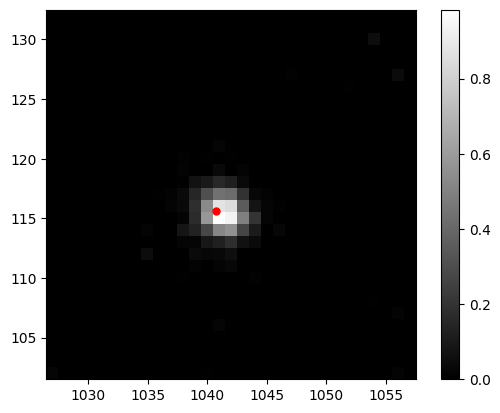

In [264]:

center= 15

ystart, yend = y_cen - center, y_cen + center + 1
xstart, xend = x_cen - center, x_cen + center + 1

smol_data = sci_data[ystart:yend, xstart:xend]

import matplotlib.pyplot as plt
#draw dot on center
# FITS convention: pixel [0,0] is at bottom-left corner, centered at (1,1) with left and bottom at 0.5
extent = [xstart + 0.5, xend + 0.5, ystart + 0.5, yend + 0.5]

plt.plot(x_cen_unrounded, y_cen_unrounded, 'ro', markersize=5)

plt.imshow(imageprocessing(smol_data), cmap='gray', origin='lower', extent=extent)
plt.colorbar()



# Extract 2D Gaussian Fit (Cumulative PSF) Parameters

In [ ]:
aoi=smol_data
# offset is the center of the image
# run a 2d symmetric gaussian fit on aoi
from scipy.optimize import curve_fit
def gaussian_2d(xy, amp, xo, yo, sigma, offset):
    x, y = xy
    g = offset + amp * np.exp(-(((x - xo) ** 2 + (y - yo) ** 2) / (2 * sigma ** 2)))
    return g.ravel()


x = np.linspace(0, aoi.shape[1] - 1, aoi.shape[1])
y = np.linspace(0, aoi.shape[0] - 1, aoi.shape[0])
x, y = np.meshgrid(x, y)
initial_guess = (aoi.max(), center, center, 1, aoi.min())
popt, pcov = curve_fit(gaussian_2d, (x, y), aoi.ravel(), p0=initial_guess)
print(f"Fitted parameters: Amplitude={popt[0]}, X0={popt[1]}, Y0={popt[2]}, Sigma={popt[3]}, Offset(background noise level)={popt[4]}")



Fitted parameters: Amplitude=620.9587719704532, X0=14.402767363064061, Y0=13.358124822366339, Sigma=1.00477720295635, Offset(background noise level)=2.3985556850101624


PARAMETERS ARE CALCULATED ON NORMAL MACHINE COORDINATES where the first pixel is regarded as 0,0
So the fitted values, on representation, need to be adjusted

## Only Visualization

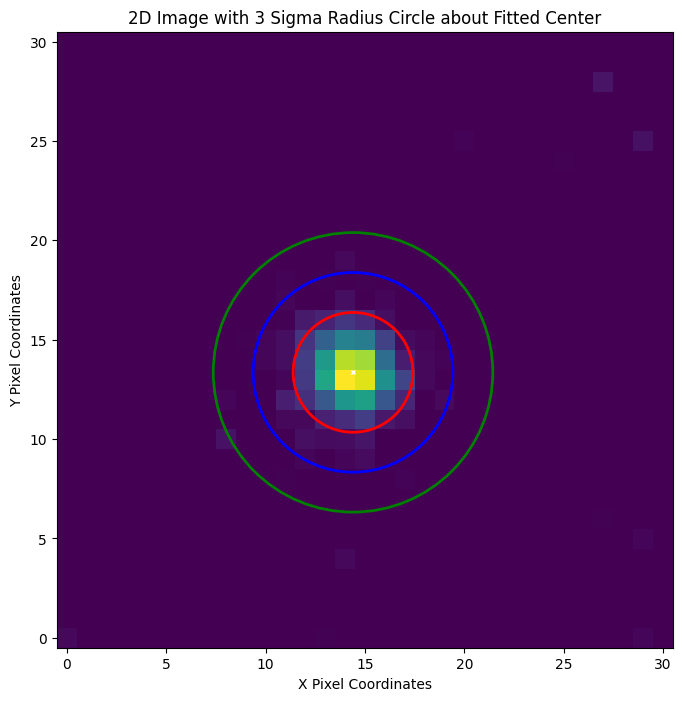

In [266]:
# plot the 2d image with 3 sigma radius circle about fitted center
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(imageprocessing(aoi), cmap='viridis', origin='lower')

# 3 sigma, 5 sigma, 7 sigma circles
sigma_fit = popt[3]
xo_fit = popt[1]
yo_fit = popt[2]
circle_3sigma = patches.Circle((xo_fit, yo_fit), 3*sigma_fit, edgecolor='red', facecolor='none', lw=2, label='3 Sigma')
ax.add_patch(circle_3sigma)
circle_5sigma = patches.Circle((xo_fit, yo_fit), 5*sigma_fit, edgecolor='blue', facecolor='none', lw=2, label='5 Sigma')
ax.add_patch(circle_5sigma)
circle_7sigma = patches.Circle((xo_fit, yo_fit), 7*sigma_fit, edgecolor='green', facecolor='none', lw=2, label='7 Sigma')
ax.add_patch(circle_7sigma)

#draw center point
ax.plot(xo_fit, yo_fit, 'wx', markersize=3, label='Fitted Center')

ax.set_title('2D Image with 3 Sigma Radius Circle about Fitted Center')
ax.set_xlabel('X Pixel Coordinates')
ax.set_ylabel('Y Pixel Coordinates')

plt.show()

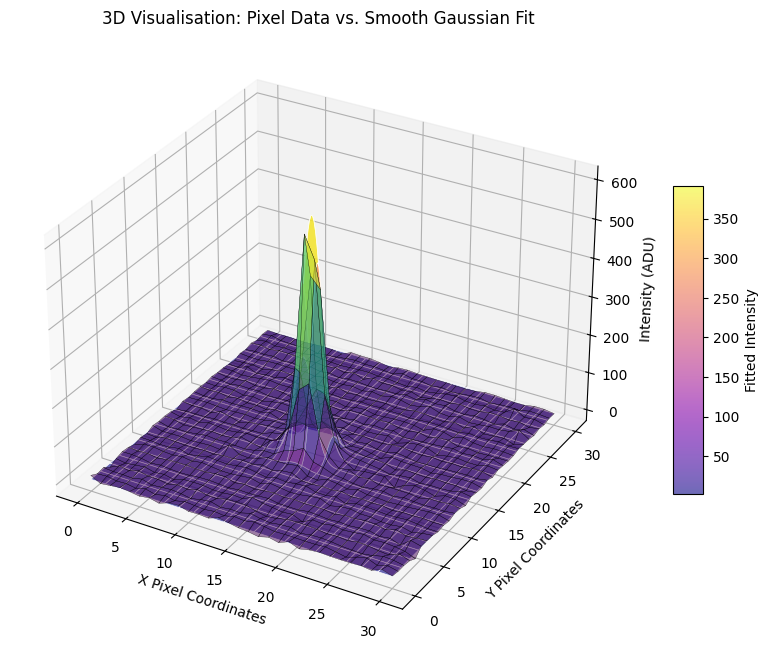

In [267]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X_pix, Y_pix = np.meshgrid(np.arange(aoi.shape[1]), np.arange(aoi.shape[0]))

# --- Part A: Plot the "Blocky" Sensor Data ---
# We plot the actual pixel values as a rough surface.
# We use a colormap (viridis) that maps low values to purple and high to yellow.
# alpha=0.5 makes it semi-transparent so we can see the fit through it/over it.
data_surf = ax.plot_surface(X_pix, Y_pix, aoi, cmap='viridis', 
                            linewidth=0.2, edgecolors='k', alpha=0.5, label='Pixel Data')


# --- Part B: Generate and Plot the Smooth Gaussian Mesh ---

# 1. Create a dense grid for smoothness. 
# Instead of N points, we use e.g., 200 points over the same spatial extent.
smoothness_factor = 200 
x_smooth = np.linspace(0, aoi.shape[1] - 1, smoothness_factor)
y_smooth = np.linspace(0, aoi.shape[0] - 1, smoothness_factor)
X_smooth, Y_smooth = np.meshgrid(x_smooth, y_smooth)

# 2. Calculate the fitted Gaussian heights on this new dense grid.
# Important: popt contains the 5 parameters found by curve_fit. Let's unpack them for clarity.
amp_fit, xo_fit, yo_fit, sigma_fit, offset_fit = popt

# We calculate the 2D gaussian using the smooth coordinates and fitted parameters.
# Note: We don't use the .ravel() version of the function here, we want the 2D shape.
Z_smooth = offset_fit + amp_fit * np.exp(-(((X_smooth - xo_fit)**2 + (Y_smooth - yo_fit)**2) / (2 * sigma_fit**2)))

# 3. Plot the smooth surface.
# We use a different colormap (plasma) to distinguish it visually.
# rstride and cstride control the density of the wireframe lines drawn on top of the surface.
fit_surf = ax.plot_surface(X_smooth, Y_smooth, Z_smooth, cmap='plasma', 
                           alpha=0.6, rstride=10, cstride=10, 
                           linewidth=0.5, edgecolors='w', shade=True)

# --- Part C: Aesthetics ---
ax.set_xlabel('X Pixel Coordinates')
ax.set_ylabel('Y Pixel Coordinates')
ax.set_zlabel('Intensity (ADU)')
ax.set_title('3D Visualisation: Pixel Data vs. Smooth Gaussian Fit')

# Add a colorbar to give context to heights
fig.colorbar(fit_surf, ax=ax, shrink=0.5, aspect=10, label='Fitted Intensity')

# Adjust the viewing angle for a better perspective
ax.view_init(elev=30, azim=-60)

plt.show()

# Aperture Photometry

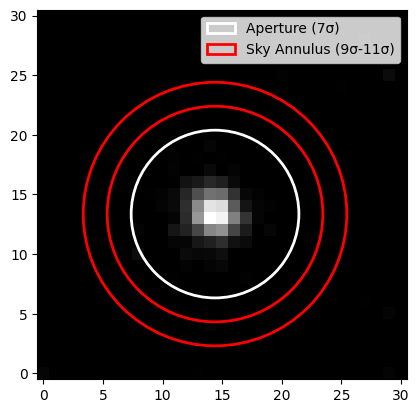

In [276]:
from photutils.aperture import CircularAnnulus, CircularAperture
positions = [(xo_fit, yo_fit)]
aperture = CircularAperture(positions, r=7*sigma_fit)
annulus_aperture = CircularAnnulus(positions, r_in=9*sigma_fit, r_out=11*sigma_fit)

import matplotlib.pyplot as plt
plt.imshow(imageprocessing(aoi), cmap='gray', origin='lower', interpolation='nearest')
ap_patches = aperture.plot(color='white', lw=2, label='Aperture (7σ)')
annulus_patches = annulus_aperture.plot(color='red', lw=2, label='Sky Annulus (9σ-11σ)')
plt.legend()

In [ ]:
from astropy.stats import SigmaClip
from photutils.aperture import ApertureStats, aperture_photometry
#these functions support error propogation if you provide an uncertainty array

sigclip = SigmaClip(sigma=3.0,maxiters=10)
aper_stats = ApertureStats(aoi, aperture, sigma_clip=None)
bkg_stats = ApertureStats(aoi, annulus_aperture, sigma_clip=sigclip)

print("3sigma clipped annulus background median",bkg_stats.median)
total_bkg = bkg_stats.median * aper_stats.sum_aper_area.value

apersum_bkgsum = aper_stats.sum - total_bkg
print("Aperture Sum minus Background Sum:", apersum_bkgsum)

3sigma clipped annulus background median [1.0732882]
Aperture Sum minus Background Sum: [4760.4272375]
